# Calcium Imaging Pipeline

This tutorial builds a complete calcium imaging analysis pipeline using DataJoint. You'll learn to:

- **Import** raw imaging data from TIFF files
- **Segment** cells using parameterized detection
- **Extract** fluorescence traces from detected ROIs
- Use **Lookup tables** for analysis parameters
- Use **Part tables** for one-to-many results

## The Pipeline

<img src="/images/calcium-pipeline.svg" alt="Calcium Imaging Pipeline" width="700">

**Legend:** Green = Manual, Gray = Lookup, Blue = Imported, Red = Computed, White = Part

Each scan produces a TIFF movie. We compute an average frame, segment cells using threshold-based detection, and extract fluorescence traces for each detected ROI.

## Setup

In [1]:
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import io
from scipy import ndimage

schema = dj.Schema('tutorial_calcium_imaging')

# Data directory (relative to this notebook)
DATA_DIR = Path('./data')

[2026-01-20 15:56:34,034][INFO]: DataJoint 2.1.0a2 connected to postgres@127.0.0.1:5432


## Manual Tables: Experiment Metadata

We start with tables for subjects, sessions, and scan metadata. These are **Manual tables** - data entered by experimenters or recording systems.

In [2]:
@schema
class Mouse(dj.Manual):
    definition = """
    mouse_id : int32
    ---
    dob : date
    sex : enum('M', 'F', 'unknown')
    """


@schema
class Session(dj.Manual):
    definition = """
    -> Mouse
    session_date : date
    ---
    experimenter : varchar(100)
    """


@schema
class Scan(dj.Manual):
    definition = """
    -> Session
    scan_idx : int16
    ---
    depth : float32           # imaging depth (um)
    wavelength : float32      # laser wavelength (nm)
    laser_power : float32     # laser power (mW)
    fps : float32             # frames per second
    file_name : varchar(128)  # TIFF filename
    """

### Insert Sample Data

In [3]:
# Insert mouse
Mouse.insert1(
    {'mouse_id': 0, 'dob': '2017-03-01', 'sex': 'M'},
    skip_duplicates=True
)

# Insert session
Session.insert1(
    {'mouse_id': 0, 'session_date': '2017-05-15', 'experimenter': 'Alice'},
    skip_duplicates=True
)

# Insert scans (we have 3 TIFF files)
Scan.insert([
    {'mouse_id': 0, 'session_date': '2017-05-15', 'scan_idx': 1,
     'depth': 150, 'wavelength': 920, 'laser_power': 26, 'fps': 15,
     'file_name': 'example_scan_01.tif'},
    {'mouse_id': 0, 'session_date': '2017-05-15', 'scan_idx': 2,
     'depth': 200, 'wavelength': 920, 'laser_power': 24, 'fps': 15,
     'file_name': 'example_scan_02.tif'},
    {'mouse_id': 0, 'session_date': '2017-05-15', 'scan_idx': 3,
     'depth': 250, 'wavelength': 920, 'laser_power': 25, 'fps': 15,
     'file_name': 'example_scan_03.tif'},
], skip_duplicates=True)

Scan()

mouse_id None,session_date None,scan_idx,depth imaging depth (um),wavelength laser wavelength (nm),laser_power laser power (mW),fps frames per second,file_name TIFF filename
0,2017-05-15,1,150.0,920.0,26.0,15.0,example_scan_01.tif
0,2017-05-15,2,200.0,920.0,24.0,15.0,example_scan_02.tif
0,2017-05-15,3,250.0,920.0,25.0,15.0,example_scan_03.tif


## Imported Table: Average Frame

An **Imported table** pulls data from external files. Here we load each TIFF movie and compute the average frame across all time points.

The `make()` method defines how to compute one entry. DataJoint's `populate()` calls it for each pending entry.

In [4]:
@schema
class AverageFrame(dj.Imported):
    definition = """
    -> Scan
    ---
    average_frame : <blob>    # mean fluorescence across frames
    """

    def make(self, key):
        # Get filename from Scan table
        file_name = (Scan & key).fetch1('file_name')
        file_path = DATA_DIR / file_name
        
        # Load TIFF and compute average
        movie = io.imread(file_path)
        avg_frame = movie.mean(axis=0)
        
        # Insert result
        self.insert1({**key, 'average_frame': avg_frame})
        print(f"Processed {file_name}: {movie.shape[0]} frames")

In [5]:
# Populate computes all pending entries
AverageFrame.populate(display_progress=True)

AverageFrame:   0%|          | 0/3 [00:00<?, ?it/s]

AverageFrame: 100%|██████████| 3/3 [00:00<00:00, 76.24it/s]

Processed example_scan_01.tif: 100 frames
Processed example_scan_02.tif: 100 frames
Processed example_scan_03.tif: 100 frames


{'success_count': 3, 'error_list': []}

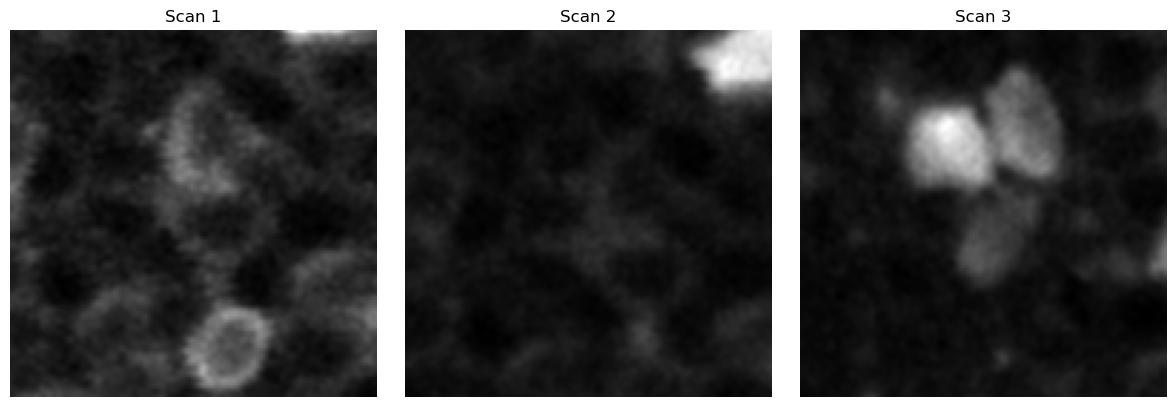

In [6]:
# Visualize average frames
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, key in zip(axes, AverageFrame.keys()):
    avg = (AverageFrame & key).fetch1('average_frame')
    ax.imshow(avg, cmap='gray')
    ax.set_title(f"Scan {key['scan_idx']}")
    ax.axis('off')
plt.tight_layout()

## Lookup Table: Segmentation Parameters

A **Lookup table** stores parameter sets that don't change often. This lets us run the same analysis with different parameters and compare results.

Our cell segmentation has two parameters:
- `threshold`: intensity threshold for detecting bright regions
- `min_size`: minimum blob size (filters out noise)

In [7]:
@schema
class SegmentationParam(dj.Lookup):
    definition = """
    seg_param_id : int16
    ---
    threshold : float32    # intensity threshold
    min_size : int32       # minimum blob size (pixels)
    """
    
    # Pre-populate with parameter sets to try
    contents = [
        {'seg_param_id': 1, 'threshold': 50.0, 'min_size': 50},
        {'seg_param_id': 2, 'threshold': 60.0, 'min_size': 50},
    ]

SegmentationParam()

seg_param_id,threshold intensity threshold,min_size minimum blob size (pixels)
1,50.0,50
2,60.0,50


## Computed Table with Part Table: Segmentation

A **Computed table** derives data from other DataJoint tables. Here, `Segmentation` depends on both `AverageFrame` and `SegmentationParam` - DataJoint will compute all combinations.

Since each segmentation produces multiple ROIs, we use a **Part table** (`Roi`) to store the individual masks. The master table stores summary info; part tables store detailed results.

In [8]:
@schema
class Segmentation(dj.Computed):
    definition = """
    -> AverageFrame
    -> SegmentationParam
    ---
    num_rois : int16          # number of detected ROIs
    segmented_mask : <blob>   # labeled mask image
    """

    class Roi(dj.Part):
        definition = """
        -> master
        roi_idx : int16
        ---
        mask : <blob>         # binary mask for this ROI
        center_x : float32    # ROI center x coordinate
        center_y : float32    # ROI center y coordinate
        """

    def make(self, key):
        # Fetch inputs
        avg_frame = (AverageFrame & key).fetch1('average_frame')
        threshold, min_size = (SegmentationParam & key).fetch1('threshold', 'min_size')
        
        # Threshold to get binary mask
        binary_mask = avg_frame > threshold
        
        # Label connected components
        labeled, num_labels = ndimage.label(binary_mask)
        
        # Filter by size and extract ROIs
        roi_masks = []
        for i in range(1, num_labels + 1):  # 0 is background
            roi_mask = (labeled == i)
            if roi_mask.sum() >= min_size:
                roi_masks.append(roi_mask)
        
        # Re-label the filtered mask
        final_mask = np.zeros_like(labeled)
        for i, mask in enumerate(roi_masks, 1):
            final_mask[mask] = i
        
        # Insert master entry
        self.insert1({
            **key,
            'num_rois': len(roi_masks),
            'segmented_mask': final_mask
        })
        
        # Insert part entries (one per ROI)
        for roi_idx, mask in enumerate(roi_masks):
            # Compute center of mass
            cy, cx = ndimage.center_of_mass(mask)
            self.Roi.insert1({
                **key,
                'roi_idx': roi_idx,
                'mask': mask,
                'center_x': cx,
                'center_y': cy
            })
        
        print(f"Scan {key['scan_idx']}, params {key['seg_param_id']}: {len(roi_masks)} ROIs")

In [9]:
# Populate all AverageFrame x SegmentationParam combinations
Segmentation.populate(display_progress=True)

Segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Segmentation: 100%|██████████| 6/6 [00:00<00:00, 135.03it/s]

Scan 1, params 1: 6 ROIs
Scan 2, params 1: 6 ROIs
Scan 3, params 1: 9 ROIs
Scan 1, params 2: 3 ROIs
Scan 2, params 2: 2 ROIs
Scan 3, params 2: 3 ROIs


{'success_count': 6, 'error_list': []}

In [10]:
# View results summary
Segmentation()

mouse_id None,session_date None,scan_idx None,seg_param_id None,num_rois number of detected ROIs,segmented_mask labeled mask image
0,2017-05-15,1,1,6,<blob>
0,2017-05-15,1,2,3,<blob>
0,2017-05-15,2,1,6,<blob>
0,2017-05-15,2,2,2,<blob>
0,2017-05-15,3,1,9,<blob>
0,2017-05-15,3,2,3,<blob>


In [11]:
# View individual ROIs
Segmentation.Roi()

mouse_id None,session_date None,scan_idx None,seg_param_id None,roi_idx,mask binary mask for this ROI,center_x ROI center x coordinate,center_y ROI center y coordinate
0,2017-05-15,1,1,0,<blob>,109.95531,2.2681565
0,2017-05-15,1,1,1,<blob>,62.761467,45.28991
0,2017-05-15,1,1,2,<blob>,1.6376811,54.724636
0,2017-05-15,1,1,3,<blob>,108.045456,81.295456
0,2017-05-15,1,1,4,<blob>,123.35514,100.0
0,2017-05-15,1,1,5,<blob>,75.53095,110.15819
0,2017-05-15,1,2,0,<blob>,109.314514,1.5806452
0,2017-05-15,1,2,1,<blob>,62.8247,46.231075
0,2017-05-15,1,2,2,<blob>,74.85655,110.27859
0,2017-05-15,2,1,0,<blob>,85.938774,6.0068026


### Visualize Segmentation Results

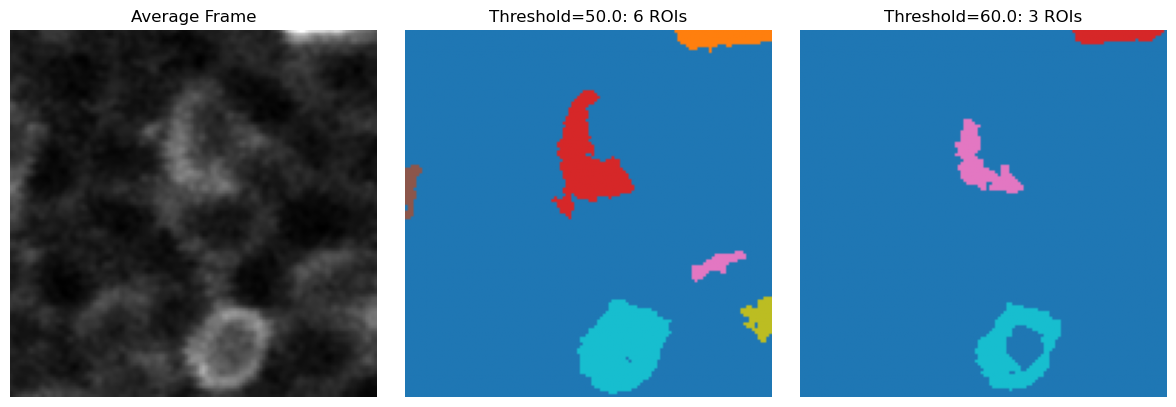

In [12]:
# Compare segmentation with different parameters for scan 1
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

key = {'mouse_id': 0, 'session_date': '2017-05-15', 'scan_idx': 1}
avg_frame = (AverageFrame & key).fetch1('average_frame')

axes[0].imshow(avg_frame, cmap='gray')
axes[0].set_title('Average Frame')
axes[0].axis('off')

for ax, param_id in zip(axes[1:], [1, 2]):
    seg_key = {**key, 'seg_param_id': param_id}
    mask, num_rois = (Segmentation & seg_key).fetch1('segmented_mask', 'num_rois')
    threshold = (SegmentationParam & {'seg_param_id': param_id}).fetch1('threshold')
    
    ax.imshow(avg_frame, cmap='gray')
    ax.imshow(mask, cmap='tab10', alpha=0.5 * (mask > 0))
    ax.set_title(f'Threshold={threshold}: {num_rois} ROIs')
    ax.axis('off')

plt.tight_layout()

## Fluorescence Trace Extraction

Now we extract the fluorescence time series for each ROI. This requires going back to the raw TIFF movie, so we use an **Imported table**.

The master table (`Fluorescence`) stores shared time axis; the part table (`Trace`) stores each ROI's trace.

In [13]:
@schema
class Fluorescence(dj.Imported):
    definition = """
    -> Segmentation
    ---
    timestamps : <blob>    # time for each frame (seconds)
    """

    class Trace(dj.Part):
        definition = """
        -> master
        -> Segmentation.Roi
        ---
        trace : <blob>     # fluorescence trace (mean within ROI mask)
        """

    def make(self, key):
        # Get scan info and load movie
        file_name, fps = (Scan & key).fetch1('file_name', 'fps')
        movie = io.imread(DATA_DIR / file_name)
        n_frames = movie.shape[0]
        
        # Create time axis
        timestamps = np.arange(n_frames) / fps
        
        # Insert master entry
        self.insert1({**key, 'timestamps': timestamps})
        
        # Extract trace for each ROI
        for roi_key in (Segmentation.Roi & key).keys():
            mask = (Segmentation.Roi & roi_key).fetch1('mask')
            
            # Compute mean fluorescence within mask for each frame
            trace = np.array([frame[mask].mean() for frame in movie])
            
            self.Trace.insert1({**roi_key, 'trace': trace})
        
        n_rois = len(Segmentation.Roi & key)
        print(f"Extracted {n_rois} traces from {file_name}")

In [14]:
Fluorescence.populate(display_progress=True)

Fluorescence:   0%|          | 0/6 [00:00<?, ?it/s]

Fluorescence: 100%|██████████| 6/6 [00:00<00:00, 66.04it/s]

Extracted 6 traces from example_scan_01.tif
Extracted 6 traces from example_scan_02.tif
Extracted 9 traces from example_scan_03.tif
Extracted 3 traces from example_scan_01.tif
Extracted 2 traces from example_scan_02.tif
Extracted 3 traces from example_scan_03.tif


{'success_count': 6, 'error_list': []}

### Visualize Fluorescence Traces

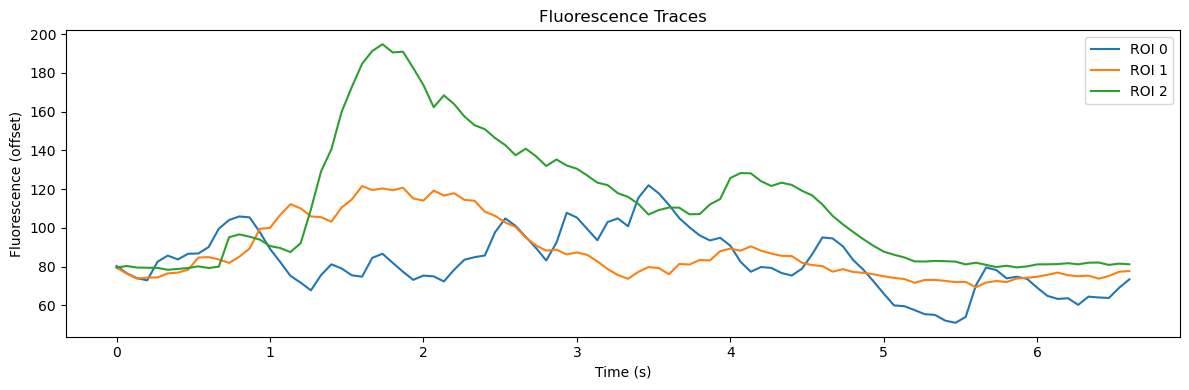

In [15]:
# Plot traces for one segmentation result
key = {'mouse_id': 0, 'session_date': '2017-05-15', 'scan_idx': 1, 'seg_param_id': 2}

timestamps = (Fluorescence & key).fetch1('timestamps')
traces = (Fluorescence.Trace & key).to_arrays('trace')

plt.figure(figsize=(12, 4))
for i, trace in enumerate(traces):
    plt.plot(timestamps, trace + i * 20, label=f'ROI {i}')  # offset for visibility

plt.xlabel('Time (s)')
plt.ylabel('Fluorescence (offset)')
plt.title('Fluorescence Traces')
plt.legend()
plt.tight_layout()

## Pipeline Diagram

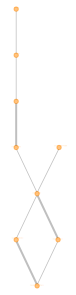

In [16]:
dj.Diagram(schema)

**Legend:**
- **Green rectangles**: Manual tables (user-entered data)
- **Gray rectangles**: Lookup tables (parameters)
- **Blue ovals**: Imported tables (data from files)
- **Red ovals**: Computed tables (derived from other tables)
- **Plain text**: Part tables (detailed results)

## Summary

This pipeline demonstrates key DataJoint patterns for imaging analysis:

| Concept | Example | Purpose |
|---------|---------|--------|
| **Manual tables** | `Mouse`, `Session`, `Scan` | Store experiment metadata |
| **Imported tables** | `AverageFrame`, `Fluorescence` | Load data from external files |
| **Computed tables** | `Segmentation` | Derive data from other tables |
| **Lookup tables** | `SegmentationParam` | Store analysis parameters |
| **Part tables** | `Roi`, `Trace` | Store one-to-many results |
| **`populate()`** | Auto-compute missing entries | Automatic pipeline execution |

### Key Benefits

1. **Parameter tracking**: Different segmentation parameters stored alongside results
2. **Reproducibility**: Re-run `populate()` to recompute after changes
3. **Data integrity**: Foreign keys ensure consistent relationships
4. **Provenance**: Clear lineage from raw data to final traces

In [17]:
# Cleanup: drop schema for re-running
schema.drop(prompt=False)